# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
# from scipy.misc import imread, imresize deprecated
import imageio
from PIL import Image
import datetime
import os
import math

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
import tensorflow as tf
tf.random.set_seed(30)


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/Gesture-Recognition-Project/Project_data/"

train  train.csv  val  val.csv


In [6]:
!ls "/content/drive/My Drive/Gesture-Recognition-Project/Project_data"

train  train.csv  val  val.csv


In [7]:

# Path to the training CSV file stored in Google Drive
train_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train.csv'

# Path to the validation CSV file stored in Google Drive
val_csv_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/val.csv'

# -------------------------------
# 2. Read and Process train.csv
# -------------------------------

# Open the training CSV file in read mode
with open(train_csv_path, 'r') as f:
    # Read all lines from the CSV file and store them in a list
    train_doc = f.readlines()  # Each line represents a data entry (e.g., video information)

# Clean the training data by removing any leading/trailing whitespace and excluding empty lines
train_doc = [line.strip() for line in train_doc if line.strip()]

# Shuffle the training data randomly to ensure that the model doesn't learn any unintended patterns
train_doc = np.random.permutation(train_doc)

# Print the first five entries of the shuffled training data for verification
print("train_doc (first 5):", train_doc[:5])

# Print the type of train_doc to confirm it's a NumPy array
print("type(train_doc):", type(train_doc))

# Print the total number of entries in the training data
print("length of train_doc:", len(train_doc))

# -------------------------------
# 3. Read and Process val.csv
# -------------------------------

# Open the validation CSV file in read mode
with open(val_csv_path, 'r') as f:
    # Read all lines from the CSV file and store them in a list
    val_doc = f.readlines()  # Each line represents a data entry for validation

# Clean the validation data by removing any leading/trailing whitespace and excluding empty lines
val_doc = [line.strip() for line in val_doc if line.strip()]

# Shuffle the validation data randomly to ensure diversity in validation batches
val_doc = np.random.permutation(val_doc)

# Print the first five entries of the shuffled validation data for verification
print("val_doc (first 5):", val_doc[:5])

# Print the type of val_doc to confirm it's a NumPy array
print("type(val_doc):", type(val_doc))

# Print the total number of entries in the validation data
print("length of val_doc:", len(val_doc))

train_doc (first 5): ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(train_doc): <class 'numpy.ndarray'>
length of train_doc: 663
val_doc (first 5): ['WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs Up_new;4'
 'WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2'
 'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180907_16_16_48_Pro_Stop Gesture_new;Stop Gesture_new;2']
type(val_doc): <class 'numpy.ndarray'>
length of val_doc: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy. In order to be able to vary the value for img_idx, we will initially set the parameter to be an optional parameter with a default value of even images-  reducing the size for processing, while still retaining a spread of values.

In [8]:
# Example: Calculating the Number of Full Batches and Leftover Items

# if total number of videos to be processed
total_videos = 29

# and if desired number of videos per batch
batch_size = 5

# Use divmod to calculate the number of full batches and the number of leftover videos
num_full_batches, leftover_videos = divmod(total_videos, batch_size)

# Display the results with clear formatting
print(f"Total Videos      : {total_videos}")
print(f"Batch Size        : {batch_size}")
print(f"Full Batches      : {num_full_batches}")
print(f"Leftover Videos   : {leftover_videos}")



Total Videos      : 29
Batch Size        : 5
Full Batches      : 5
Leftover Videos   : 4


In [9]:
def generator(source_path, folder_list, batch_size=5, img_idx=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26], y=80, z=80):
    # Print initial configuration details for debugging and verification
    print('Source path = ', source_path, '; batch size =', batch_size, '; Image Index =', img_idx)

    # Determine the number of frames (images) per video based on the length of img_idx
    x = len(img_idx)  # frames per video

    # Target dimensions for all images (height and width)
    # These are set via function parameters with default values y=80 and z=80

    # Infinite loop to continuously yield batches
    while True:
        # Debugging information: print the first 5 folders, type, and total number of folders
        print("folder_list:", folder_list[:5])  # Show first 5 entries for quick inspection
        print("type(folder_list):", type(folder_list))  # Confirm the type of folder_list (e.g., list, numpy array)
        print("length of folder_list:", len(folder_list))  # Total number of folders/videos to process

        # Randomly shuffle the folder list to ensure batches are randomized each epoch
        t = np.random.permutation(folder_list)

        # Calculate the number of full batches and the number of leftover videos
        num_batches, leftover_videos = divmod(len(t), batch_size)  # e.g., 29 videos split into 5 batches results in 5 full batches and 4 leftovers

        # ========================
        # Main Loop for Full Batches
        # ========================
        for batch in range(num_batches):
            # Inform which batch is currently being processed
            print(f"Processing batch {batch + 1}/{num_batches}")

            # Initialize an empty array to hold batch data
            # Shape: (batch_size, number of frames per video, height, width, 3 color channels)
            batch_data = np.zeros((batch_size, x, y, z, 3))  # 5D array for batch data

            # Initialize an empty array for one-hot encoded labels
            # Shape: (batch_size, number of classes), assuming 5 classes
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoded labels

            # Iterate over each video in the current batch
            for folder in range(batch_size):
                # Extract folder name and label from the shuffled list
                # Assumes each entry in folder_list is a string formatted with semicolons, e.g., "folder_name;info;label"
                folder_name = t[folder + (batch * batch_size)].strip().split(';')[0]
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])

                # Construct the full path to the current folder
                folder_path = os.path.join(source_path, folder_name)

                # List all image files in the current folder
                imgs = os.listdir(folder_path)
                print(f"  Folder {folder_name} - {len(imgs)} images found")  # Debug: number of images in the folder

                # Iterate over each specified image index to select frames
                for idx, item in enumerate(img_idx):
                    try:
                        # Construct the full path to the current image
                        img_path = os.path.join(folder_path, imgs[item])

                        # Read the image using imageio and convert to float32 for normalization
                        image = imageio.imread(img_path).astype(np.float32)

                        # Resize the image to the target dimensions (y, z) using PIL for consistency
                        image_resized = Image.fromarray(image.astype('uint8')).resize((z, y))
                        image_resized = np.array(image_resized)  # Convert back to NumPy array

                        # Normalize pixel values to the range [0, 1] and assign to batch_data
                        # Separate channels are stored individually
                        batch_data[folder, idx, :, :, 0] = image_resized[..., 0] / 255  # Red channel
                        batch_data[folder, idx, :, :, 1] = image_resized[..., 1] / 255  # Green channel
                        batch_data[folder, idx, :, :, 2] = image_resized[..., 2] / 255  # Blue channel

                    except IndexError:
                        # Handle cases where the specified img_idx is out of range for the current folder's images
                        print(f"ERROR: img_idx {item} out of range for {folder_name}")
                        continue  # Skip to the next image index
                    except Exception as e:
                        # Handle any other exceptions that may occur during image processing
                        print(f"ERROR processing image {img_path}: {e}")
                        raise e  # Re-raise the exception after logging

                # Assign the one-hot encoded label for the current video
                batch_labels[folder, label] = 1

            # Yield the processed batch data and corresponding labels
            yield batch_data, batch_labels

        # ========================
        # Leftover Batch Handling
        # ========================
        if leftover_videos != 0:
            # Inform that leftover videos (not forming a full batch) are being processed
            print("Processing leftover videos...")

            # Initialize arrays for leftover batch data and labels
            batch_data = np.zeros((leftover_videos, x, y, z, 3))  # Shape: (leftover_videos, x, y, z, 3)
            batch_labels = np.zeros((leftover_videos, 5))  # Shape: (leftover_videos, 5)

            # Iterate over each leftover video
            for i in range(leftover_videos):
                # Calculate the index of the leftover video in the shuffled list
                video_index = num_batches * batch_size + i

                # Extract folder name and label from the shuffled list
                folder_name = t[video_index].strip().split(';')[0]
                label = int(t[video_index].strip().split(';')[2])

                # Construct the full path to the current folder
                folder_path = os.path.join(source_path, folder_name)

                # List all image files in the current folder
                imgs = os.listdir(folder_path)

                # Iterate over each specified image index to select frames
                for idx, item in enumerate(img_idx):
                    try:
                        # Construct the full path to the current image
                        img_path = os.path.join(folder_path, imgs[item])

                        # Read the image using imageio and convert to float32 for normalization
                        image = imageio.imread(img_path).astype(np.float32)

                        # Resize the image to the target dimensions (y, z) using PIL for consistency
                        image_resized = Image.fromarray(image.astype('uint8')).resize((z, y))
                        image_resized = np.array(image_resized)  # Convert back to NumPy array

                        # Normalize pixel values to the range [0, 1] and assign to batch_data
                        # Separate channels are stored individually
                        batch_data[i, idx, :, :, 0] = image_resized[..., 0] / 255  # Red channel
                        batch_data[i, idx, :, :, 1] = image_resized[..., 1] / 255  # Green channel
                        batch_data[i, idx, :, :, 2] = image_resized[..., 2] / 255  # Blue channel

                    except IndexError:
                        # Handle cases where the specified img_idx is out of range for the current folder's images
                        print(f"ERROR: img_idx {item} out of range for {folder_name}")
                        continue  # Skip to the next image index
                    except Exception as e:
                        # Handle any other exceptions that may occur during image processing
                        print(f"ERROR processing image {img_path}: {e}")
                        raise e  # Re-raise the exception after logging

                # Assign the one-hot encoded label for the current video
                batch_labels[i, label] = 1

            # Yield the processed leftover batch data and corresponding labels
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()

train_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train'
val_path = '/content/drive/My Drive/Gesture-Recognition-Project/Project_data/val'

# Check if train and val paths exist
if os.path.exists(train_path):
    print(f"Train path exists: {train_path}")
    print("Files in train path:", os.listdir(train_path))
else:
    print(f"ERROR: Train path does NOT exist: {train_path}")

if os.path.exists(val_path):
    print(f"Validation path exists: {val_path}")
    print("Files in validation path:", os.listdir(val_path))
else:
    print(f"ERROR: Validation path does NOT exist: {val_path}")



# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

Train path exists: /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train
Files in train path: ['WIN_20180907_15_35_09_Pro_Right Swipe_new', 'WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_38_24_Pro_Right Swipe_new', 'WIN_20180907_15_39_51_Pro_Stop Gesture_new', 'WIN_20180907_15_38_35_Pro_Thumbs Down_new', 'WIN_20180907_15_40_55_Pro_Thumbs Up_new', 'WIN_20180907_15_39_54_Pro_Thumbs Up_new', 'WIN_20180907_15_40_26_Pro_Thumbs Down_new', 'WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_43_28_Pro_Right Swipe_new', 'WIN_20180907_15_41_54_Pro_Right Swipe_new', 'WIN_20180907_15_43_40_Pro_Stop Gesture_new', 'WIN_20180907_15_44_13_Pro_Stop Gesture_new', 'WIN_20180907_15_43_58_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_15_45_30_Pro_Thumbs Up_new', 'WIN_20180907_15_44_32_Pro_Thumbs Down_new', 'WIN_20180907_15_44_36_Pro_Right Swipe_new', 'WIN_20180907_15_44_55_Pro_Stop Gesture_new', 'WIN_20180907_15_45_56_Pro_Thumbs Down

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# Example hyperparameters:
num_frames = 13          # e.g. len(img_idx)
image_height = 80        # e.g. post-resize or original image height
image_width = 80         # e.g. post-resize or original image width
num_classes = 5          # e.g. gestures = 5

# Build a lightweight 3D CNN
model = Sequential()

# 1st 3D conv block
model.add(Conv3D(16, (3,3,3),
                 input_shape=(num_frames, image_height, image_width, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd 3D conv block
model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten + Dense layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Final softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with an optimizer of your choice:
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 13, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 13, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 6, 40, 40, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 40, 40, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 6, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 3, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,457,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,653 (9.44 MB)

 Trainable params: 2,475,365 (9.44 MB)

 Non-trainable params: 288 (1.12 KB)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 13, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 13, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 6, 40, 40, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 40, 40, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 6, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 3, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,457,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,653 (9.44 MB)

 Trainable params: 2,475,365 (9.44 MB)

 Non-trainable params: 288 (1.12 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
print(train_path)
print(train_doc)


/content/drive/My Drive/Gesture-Recognition-Project/Project_data/train
['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2'
 'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2'
 'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2'
 'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2'
 'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0'
 'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180907_16_19_10_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left

In [14]:
train_generator = generator(train_path, train_doc, batch_size=32)
val_generator = generator(val_path, val_doc, batch_size=32)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
print("Length of train_doc:", len(train_doc))
print("Steps_per_epoch :", steps_per_epoch )


Length of train_doc: 663
Steps_per_epoch : 133


In [17]:
# Retrieve the next batch of data and corresponding labels from the training generator
batch_data, batch_labels = next(train_generator)

# Print the shape of the batch data to verify its dimensions
# Expected shape: (batch_size, number_of_frames_per_video, height, width, 3)
print("Batch data shape:", batch_data.shape)

# Print the shape of the batch labels to verify its dimensions
# Expected shape: (batch_size, number_of_classes)
print("Batch labels shape:", batch_labels.shape)



Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 32 ; Image Index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/20
  Folder WIN_20180926_17_24_58_Pro_Right_Swipe_new - 30 images found


<ipython-input-9-cceed1fdd760>:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180926_17_35_17_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_58_10_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_20_16_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_58_12_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_17_33_51_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_17_22_11_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_49_15_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_18_14_35_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_18_01_30_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_31_02_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_05_08_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_57_22_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_58_27_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_16_52_43_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_15_59_44_Pro_Right Swipe_new - 30 images found


In [22]:
import os
from keras.callbacks import ModelCheckpoint

# Make sure the directory exists
save_dir = '/content/drive/My Drive/Gesture-Recognition-Project/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir, 'manual_model_save.keras')

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,   # Save file every epoch (not just the best)
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'       # Saves at the end of each epoch
)



In [23]:
# ---------------------------------------------
# Define the callbacks_list HERE
# ---------------------------------------------
callbacks_list = [checkpoint]

# Now you can pass callbacks_list into model.fit
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,  # <--- Now it is defined
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)



Processing batch 2/20
  Folder WIN_20180907_16_29_23_Pro_Left Swipe_new_Left Swipe_new - 30 images found


<ipython-input-9-cceed1fdd760>:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_24_14_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180926_17_12_26_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_02_59_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_18_16_56_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_15_33_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180907_16_37_03_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180907_15_54_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found
  Folder WIN_20180926_17_18_02_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_17_37_14_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_43_11_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_59_03_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_17_35_24_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_18_08_31_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_17_37_08_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_17_01_50_Pro_Stop_ne

<ipython-input-9-cceed1fdd760>:120: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
  Folder WIN_20180907_16_24_14_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180907_15_54_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found
  Folder WIN_20180925_17_20_16_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180907_16_22_23_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180926_17_06_07_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_16_55_03_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_12_26_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_35_54_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_17_48_59_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_24_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_17_51_17_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180907_16_04_51_Pro_Left Swipe_new_Left Swipe_new - 30 images found
  Folder WIN_20180926_17_43_17_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_16_49_22_Pro_Thumbs_Down_new

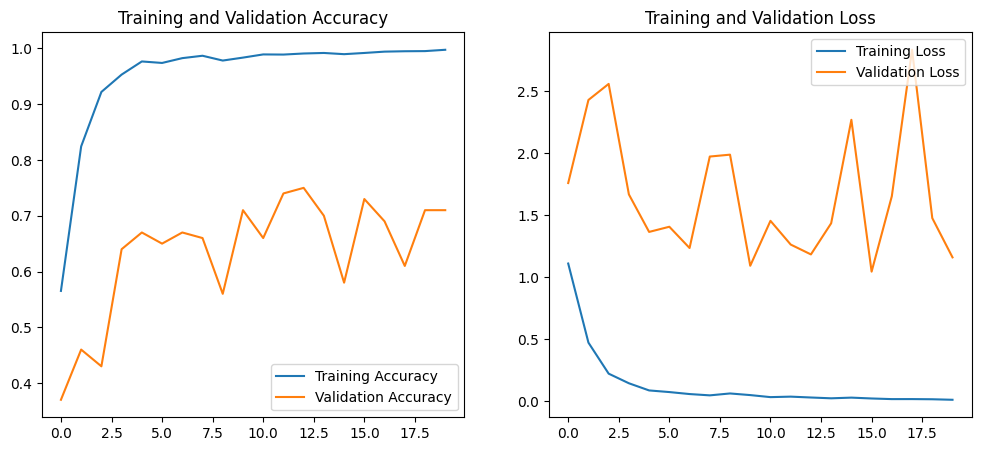

In [24]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine how many epochs were actually run
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# ---------------------------
# Subplot 1: Accuracy
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# ---------------------------
# Subplot 2: Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [25]:
final_loss, final_accuracy = model.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)


Processing batch 2/3
  Folder WIN_20180926_16_46_22_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180907_16_20_15_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_16_09_35_Pro_Thumbs Down_new - 30 images found


<ipython-input-9-cceed1fdd760>:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180926_16_57_50_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_18_23_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180907_16_29_12_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180926_17_56_52_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_16_37_56_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_33_15_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180926_17_32_15_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_33_14_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_00_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found
  Folder WIN_20180925_18_03_21_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_35_29_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_17_40_03_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_43_34_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_17_43_46_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_28_32_Pro_Thumbs_Up

<ipython-input-9-cceed1fdd760>:120: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


folder_list: ['WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs Up_new;4'
 'WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2'
 'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180907_16_16_48_Pro_Stop Gesture_new;Stop Gesture_new;2']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 100
Processing batch 1/3
  Folder WIN_20180925_17_38_43_Pro_Thumbs_Up_new - 30 images found
 3/20 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - categorical_accuracy: 0.6985 - loss: 1.3109  Folder WIN_20180926_17_24_12_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_15_42_17_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_17_04_53_Pro_Stop_new - 30 images found
  Folder WIN_20180907_15_57_43_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180907_16_17_35_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_16_46_22_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180907_16_39_59_Pro_Th

In [26]:
train_loss = history.history['loss'][-1]
train_accuracy = history.history['categorical_accuracy'][-1]  # or 'accuracy' if that's your metric key

print("Final Training Loss (from history):", train_loss)
print("Final Training Accuracy (from history):", train_accuracy)


Final Training Loss (from history): 0.01138282660394907
Final Training Accuracy (from history): 0.997620165348053


In [ ]:
# saving the best model to a keras file
model.save('/content/drive/My Drive/Gesture-Recognition-Project/manual_model_save.keras')


In [ ]:

print("Total Params:", model.count_params())

Total Params: 2475653


# Model 2: CNN + RNN Model (GRU)

In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import SGD

# Hyperparameters
num_frames = 13          # same as before, len(img_idx)
image_height = 80        # same image dimensions used in your dataset
image_width = 80
num_classes = 5
rnn_units = 32           # number of GRU units (tweak as needed)

# Build the CNN + RNN model
model2 = Sequential()

# 1) TimeDistributed CNN Block
#    Applies a 2D CNN to each frame in the sequence.
model2.add(TimeDistributed(
    Conv2D(16, (3,3), padding='same', activation='relu'),
    input_shape=(num_frames, image_height, image_width, 3)
))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

# 2) Another TimeDistributed CNN Block (optional, to increase capacity)
model2.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

# 3) Flatten the CNN output per frame
model2.add(TimeDistributed(Flatten()))

# 4) RNN Layer (GRU or LSTM)
model2.add(GRU(rnn_units, return_sequences=False))
# If you want to stack RNNs or keep sequence output, adjust return_sequences.

# 5) Dense + Dropout + BN
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# 6) Final Output Layer
model2.add(Dense(num_classes, activation='softmax'))

# Compile
optimiser = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model2.compile(
    optimizer=optimiser,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 13, 80, 80, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 13, 80, 80, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 13, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 13, 40, 40, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 13, 40, 40, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 13, 20, 20, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 13, 12800)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │       1,232,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,242,085 (4.74 MB)

 Trainable params: 1,241,797 (4.74 MB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
# For the same dataset/generator:
train_generator = generator(train_path, train_doc, batch_size, y=120, z=120)
val_generator = generator(val_path, val_doc, batch_size, y=120, z)

# Same callbacks, e.g.
callbacks_list = [checkpoint, LR]  # define your ModelCheckpoint, ReduceLROnPlateau, etc.

history2 = model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 5 ; Image Index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/132
  Folder WIN_20180926_17_52_26_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_04_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_23_23_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_45_57_Pro_Thumbs_Down_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_12_20_Pro_Right Swipe_new - 30 images found
Processing batch 2/132
  Folder WIN_20180907_16_32_11_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_29_52_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_40_22_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_39_59_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_18_02_41_Pro_Right_Swipe_new - 30 images found
Epoch 1/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 23:09 11s/step - categorical_accuracy: 0.2000 - loss: 1.6901Processing batch 3/132
  Folder WIN_20180926_16_39_58_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_15_49_56_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180926_16_40_38_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_18_26_40_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_05_58_Pro_Stop Gesture_new - 30 images found
Processing batch 4/132
  Folder WIN_20180907_15_48_25_Pro_Thumbs Down_new - 30 images found
  

<ipython-input-111-7905c8aaaac9>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
  Folder WIN_20180907_16_37_22_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180926_17_01_50_Pro_Stop_new - 30 images found
Processing batch 81/132
  Folder WIN_20180925_17_55_45_Pro_Thumbs_Down_new - 30 images found
 80/133 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - categorical_accuracy: 0.1789 - loss: 1.6321  Folder WIN_20180925_17_37_42_Pro_Stop_new - 30 images found
  Folder WIN_20180907_15_54_06_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_16_25_52_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180925_17_46_49_Pro_Left_Swipe_new - 30 images found
Processing batch 82/132
  Folder WIN_20180907_15_53_12_Pro_Thumbs Up_new - 30 images found
 81/133 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - categorical_accuracy: 0.1788 - loss: 1.6320  Folder WIN_20180926_17_35_54_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_18_12_58_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_17_11_Pro_Left Swipe_new_Lef

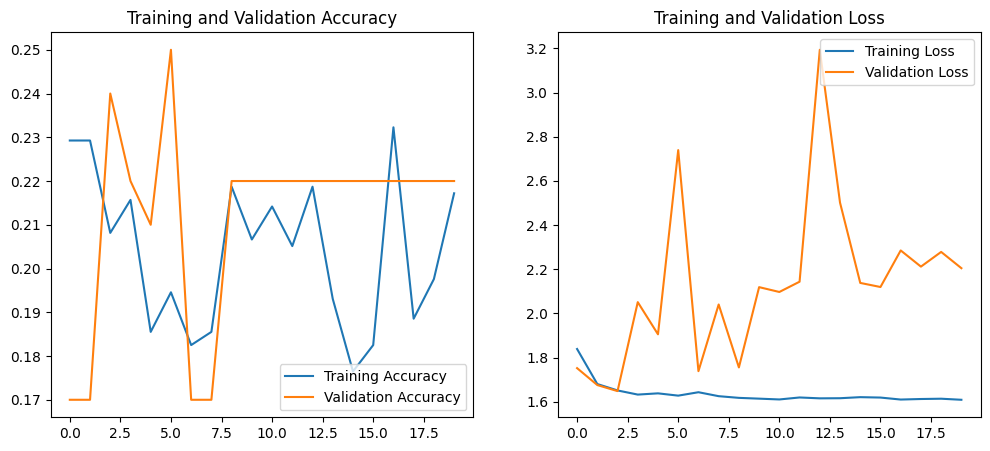

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history2
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Determine how many epochs were actually run
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# ---------------------------
# Subplot 1: Accuracy
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# ---------------------------
# Subplot 2: Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
final_loss, final_accuracy = model2.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)

Processing batch 15/20
  Folder WIN_20180926_16_48_48_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_44_04_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_17_05_38_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_36_42_Pro_Left Swipe_new_Left Swipe_new - 30 images found


<ipython-input-111-7905c8aaaac9>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_39_59_Pro_Thumbs Up_new - 30 images found
Processing batch 16/20
  Folder WIN_20180926_17_33_14_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180907_16_07_10_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180907_15_43_36_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180926_16_37_56_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_35_29_Pro_Thumbs_Down_new - 30 images found
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.4000 - loss: 1.5973Processing batch 17/20
  Folder WIN_20180925_17_52_42_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_48_16_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180925_17_49_40_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_29_34_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_12_27_Pro_Right_Swipe_new - 30 images found
Processing batch 18/20
  Folder WIN_20180907_15_42_17_Pro_Stop Gesture_new - 30 images found
 3/20 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step -

In [ ]:
print("Total Params:", model2.count_params())

Total Params: 1242085


# Model 3 - Simplified 3D CNN, but increasing the pixels from 80 to 120

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam

# Model 3 - Lighter 3D CNN with Global Average Pooling
model3 = Sequential()

# 1st 3D conv block (fewer filters, smaller kernel)
model3.add(Conv3D(8, (3,3,3),
                 input_shape=(num_frames, image_height, image_width, 3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd 3D conv block (reduce filters)
model3.add(Conv3D(16, (3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# Global Average Pooling (instead of Flatten)
model3.add(GlobalAveragePooling3D())

# Smaller Dense layers
model3.add(Dense(32, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Dense(16, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# Final softmax output layer
model3.add(Dense(num_classes, activation='softmax'))

# Compile with 'categorical_accuracy' to match the ModelCheckpoint filepath
optimizer = Adam(learning_rate=0.001)
model3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model3.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)                   │ (None, 13, 80, 80, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 13, 80, 80, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 13, 80, 80, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 6, 40, 40, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 6, 40, 40, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 6, 40, 40, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 3, 20, 20, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_2           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573 (21.77 KB)

 Trainable params: 5,429 (21.21 KB)

 Non-trainable params: 144 (576.00 B)

In [ ]:

# Create the generators (same as before)
train_generator = generator(train_path, train_doc, batch_size, y=120, z=120)
val_generator = generator(val_path, val_doc, batch_size, y=120, z=120)

# Fit the model
history3 = model3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,   # e.g. includes ModelCheckpoint referencing {categorical_accuracy}
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)

Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 5 ; Image Index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/132
  Folder WIN_20180907_16_15_15_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180926_17_37_02_Pro_Stop_new - 30 images found
  Folder WIN_20180926_16_50_32_Pro_Stop_new - 30 images found


<ipython-input-138-d3a81ad0f226>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_15_59_28_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180925_17_18_07_Pro_Thumbs_Up_new - 30 images found
Processing batch 2/132
  Folder WIN_20180925_17_40_22_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180926_16_58_12_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_56_11_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_23_26_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_26_37_Pro_Thumbs_Up_new - 30 images found
Epoch 1/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 14:44 7s/step - categorical_accuracy: 0.4000 - loss: 2.5045Processing batch 3/132
  Folder WIN_20180926_16_54_30_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_17_19_35_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_01_35_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180925_17_42_57_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_11_36_Pro_Thumbs_Down_new - 30 images found
Processing batch 4/132
  Folder WIN_20180925_18_13_15_Pro_

<ipython-input-138-d3a81ad0f226>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
  Folder WIN_20180925_17_32_52_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_21_16_Pro_Left_Swipe_new - 30 images found
Processing batch 81/132
  Folder WIN_20180907_16_43_19_Pro_Thumbs Down_new - 30 images found
 80/133 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - categorical_accuracy: 0.3355 - loss: 1.4755  Folder WIN_20180926_17_11_11_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_17_30_14_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_39_11_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_00_54_Pro_Right Swipe_new - 30 images found
Processing batch 82/132
  Folder WIN_20180907_15_55_27_Pro_Thumbs Down_new - 30 images found
 81/133 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - categorical_accuracy: 0.3361 - loss: 1.4745  Folder WIN_20180925_18_05_57_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180926_17_13_32_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180907_16_40_19_Pro_Left Swipe_

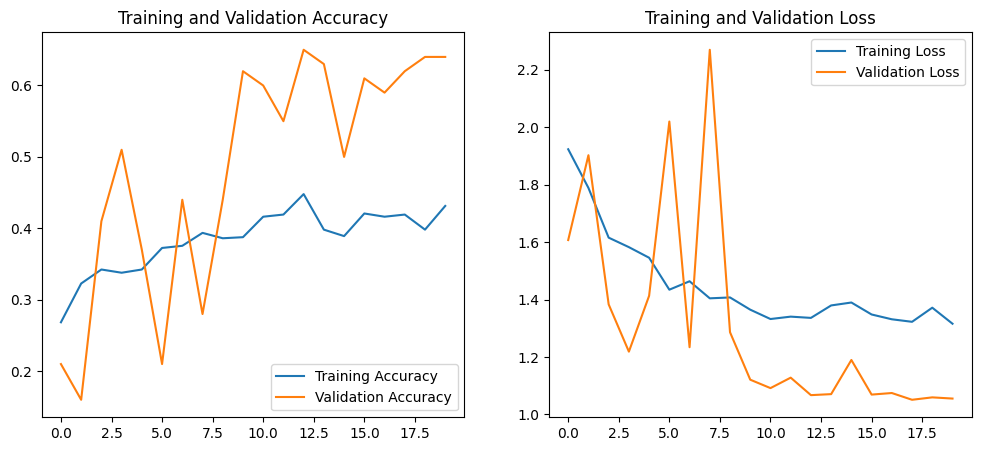

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history3
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Determine how many epochs were actually run
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# ---------------------------
# Subplot 1: Accuracy
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# ---------------------------
# Subplot 2: Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
final_loss, final_accuracy = model3.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)

Processing batch 14/20
  Folder WIN_20180925_17_52_42_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_02_09_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180907_16_05_32_Pro_Left Swipe_new_Left Swipe_new - 30 images found


<ipython-input-138-d3a81ad0f226>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_20_53_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180907_16_14_40_Pro_Right Swipe_new - 30 images found
Processing batch 15/20
  Folder WIN_20180926_17_56_52_Pro_Right_Swipe_new - 30 images found
  Folder WIN_20180925_17_40_03_Pro_Stop_new - 30 images found
  Folder WIN_20180925_18_03_21_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180925_17_35_04_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180907_16_05_10_Pro_Right Swipe_new - 30 images found
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.6000 - loss: 1.0432Processing batch 16/20
  Folder WIN_20180925_17_30_40_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_16_48_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_16_25_44_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_15_52_05_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180907_16_14_16_Pro_Stop Gesture_new - 30 images found
Processing batch 17/20
  Folder WIN_20180925_17_59_48_Pro

In [ ]:
print("Total Params:", model3.count_params())

Total Params: 5573


#  Model 4 - Simplified 3D CNN, but increasing the pixels from 80 to 120, and including all images in the video

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam

# Model 3 - Lighter 3D CNN with Global Average Pooling
model4 = Sequential()

# 1st 3D conv block (fewer filters, smaller kernel)
model4.add(Conv3D(8, (3,3,3),
                 input_shape=(num_frames, image_height, image_width, 3),
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# 2nd 3D conv block (reduce filters)
model4.add(Conv3D(16, (3,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# Global Average Pooling (instead of Flatten)
model4.add(GlobalAveragePooling3D())

# Smaller Dense layers
model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# increasing the dropout rate
model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# Final softmax output layer
model4.add(Dense(num_classes, activation='softmax'))

# Compile with 'categorical_accuracy' to match the ModelCheckpoint filepath
optimizer = Adam(learning_rate=0.001)
model4.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model4.summary()




Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 13, 80, 80, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 13, 80, 80, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 13, 80, 80, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 6, 40, 40, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 6, 40, 40, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 6, 40, 40, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 6, 40, 40, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_21 (MaxPooling3D)      │ (None, 3, 20, 20, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_4           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,245 (24.39 KB)

 Trainable params: 6,069 (23.71 KB)

 Non-trainable params: 176 (704.00 B)

In [ ]:
# Create the generators (same as before)
train_generator = generator(train_path, train_doc, batch_size, img_idx=[0, 1,2,3, 4,5, 6,7, 8,9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], y=120, z=120)
val_generator = generator(val_path, val_doc, batch_size, y=120, z=120)

# Fit the model
history4 = model4.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,   # e.g. includes ModelCheckpoint referencing {categorical_accuracy}
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)

Source path =  /content/drive/My Drive/Gesture-Recognition-Project/Project_data/train ; batch size = 5 ; Image Index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
folder_list: ['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0']
type(folder_list): <class 'numpy.ndarray'>
length of folder_list: 663
Processing batch 1/132
  Folder WIN_20180925_17_18_28_Pro_Left_Swipe_new - 30 images found


<ipython-input-138-d3a81ad0f226>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180925_17_40_41_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180907_16_30_30_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180926_16_56_54_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_23_39_Pro_Left_Swipe_new - 30 images found
Processing batch 2/132
  Folder WIN_20180907_16_12_16_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180907_16_00_27_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_57_31_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_43_30_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180925_17_21_28_Pro_Left_Swipe_new - 30 images found
Epoch 1/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 15:25 7s/step - categorical_accuracy: 0.2000 - loss: 2.4757Processing batch 3/132
  Folder WIN_20180926_16_54_07_Pro_Stop_new - 30 images found
  Folder WIN_20180926_17_05_32_Pro_Stop_new - 30 images found
  Folder WIN_20180907_16_29_13_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180925_17_26_51_Pro_Left_Swipe_new - 30 image

<ipython-input-138-d3a81ad0f226>:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


Streaming output truncated to the last 5000 lines.
Processing batch 80/132
  Folder WIN_20180907_16_29_23_Pro_Left Swipe_new_Left Swipe_new - 30 images found
 79/133 ━━━━━━━━━━━━━━━━━━━━ 49s 916ms/step - categorical_accuracy: 0.5025 - loss: 1.2431  Folder WIN_20180907_16_15_15_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180907_15_54_06_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180907_16_04_13_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180926_16_46_40_Pro_Left_Swipe_new - 30 images found
Processing batch 81/132
  Folder WIN_20180925_17_44_57_Pro_Thumbs_Down_new - 30 images found
 80/133 ━━━━━━━━━━━━━━━━━━━━ 48s 921ms/step - categorical_accuracy: 0.5024 - loss: 1.2431  Folder WIN_20180925_17_24_49_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_17_06_07_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_13_44_Pro_Stop_new - 30 images found
  Folder WIN_20180925_17_37_12_Pro_Thumbs_Down_new - 30 images found
Processing batch 82/132
  Fol

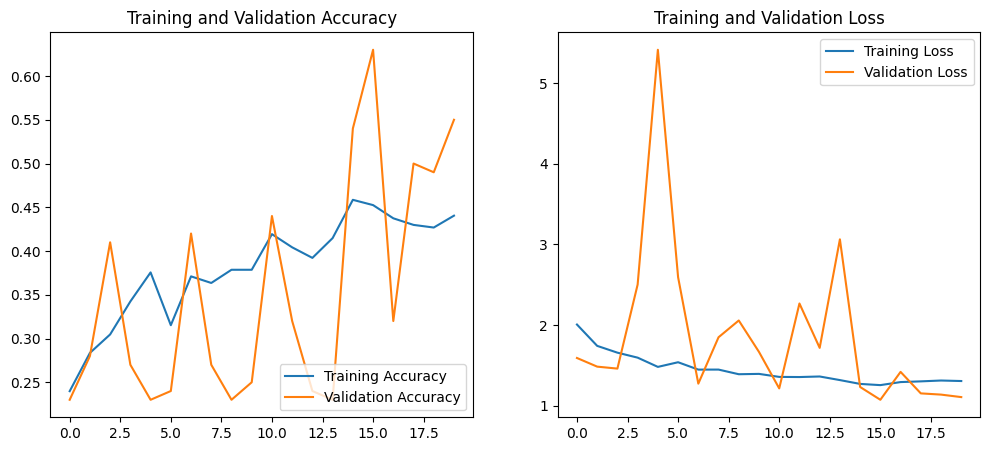

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history3
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Determine how many epochs were actually run
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# ---------------------------
# Subplot 1: Accuracy
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# ---------------------------
# Subplot 2: Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
final_loss, final_accuracy = model4.evaluate(val_generator, steps=validation_steps)
print("Final Validation Loss:", final_loss)
print("Final Validation Accuracy:", final_accuracy)

Processing batch 14/20
  Folder WIN_20180907_16_10_59_Pro_Thumbs Up_new - 30 images found
  Folder WIN_20180907_16_39_59_Pro_Thumbs Up_new - 30 images found


<ipython-input-138-d3a81ad0f226>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path).astype(np.float32)


  Folder WIN_20180907_16_17_35_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_17_09_33_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_16_48_48_Pro_Stop_new - 30 images found
Processing batch 15/20
  Folder WIN_20180907_16_25_44_Pro_Stop Gesture_new - 30 images found
  Folder WIN_20180926_17_05_38_Pro_Thumbs_Down_new - 30 images found
  Folder WIN_20180907_16_21_39_Pro_Left Swipe_new_Left Swipe_new - 30 images found
  Folder WIN_20180907_16_29_12_Pro_Thumbs Down_new - 30 images found
  Folder WIN_20180925_17_17_04_Pro_Left_Swipe_new - 30 images found
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.4000 - loss: 1.3374Processing batch 16/20
  Folder WIN_20180907_15_50_39_Pro_Right Swipe_new - 30 images found
  Folder WIN_20180926_17_21_48_Pro_Left_Swipe_new - 30 images found
  Folder WIN_20180926_16_43_34_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_06_40_Pro_Thumbs_Up_new - 30 images found
  Folder WIN_20180926_17_03_57_Pro_Righ

In [ ]:
print("Total Params:", model3.count_params())

Total Params: 5573
